In [1]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as st
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [2]:
train = pd.read_csv('../input/train_data.csv')
test = pd.read_csv('../input/test_data.csv')

In [3]:
train_ID = train.Application_ID
test_ID = test.Application_ID

y = train.Loan_Status

train.drop(['Application_ID', 'Loan_Status'], axis=1, inplace=True)
test.drop(['Application_ID'], axis=1, inplace=True)

In [4]:
ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)

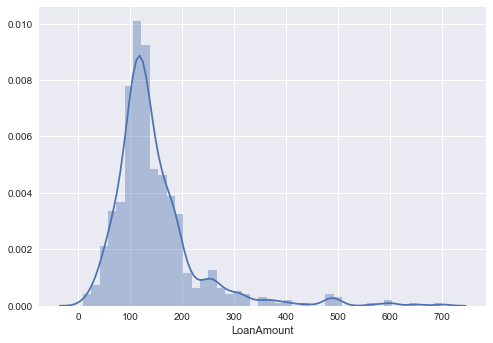

In [5]:
sns.distplot(train_test.LoanAmount.dropna())

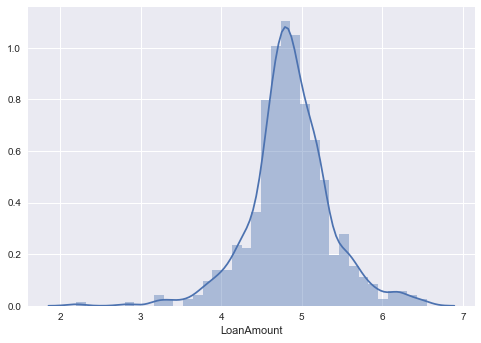

In [6]:
sns.distplot(np.log(train_test.LoanAmount).dropna())

In [7]:
train_test.loc[:, 'LoanAmount'] = np.log(train_test.LoanAmount)

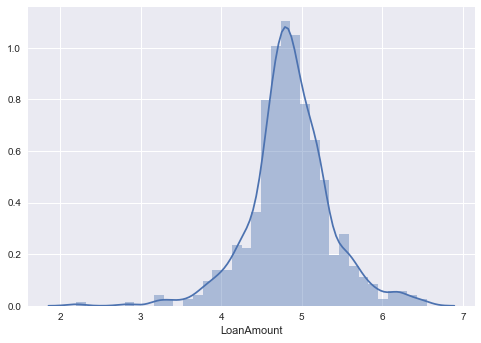

In [8]:
sns.distplot(train_test.LoanAmount.dropna())

In [9]:
train_test.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [10]:
train_test.apply(pd.Series.nunique)

Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
dtype: int64

In [11]:
train_test.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

In [12]:
train_test.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')

In [13]:
cat_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area']

In [15]:
for cat in cat_vars:
    print(train_test[cat].unique(), end='\n\n')

['M' 'F' nan]

['No' 'Yes' nan]

['0' '1' '2' '3+' nan]

['Graduate' 'Not Graduate']

['No' 'Yes' nan]

[ 360.  120.  240.   nan  180.   60.  300.  480.   36.   84.   12.]

[  1.   0.  nan]

['Urban' 'Rural' 'Semiurban']



In [16]:
train_test.loc[train_test.Dependents == '3+', ['Dependents']] = 3

In [17]:
to_int_type = ['Dependents', 'Loan_Amount_Term', 'Credit_History']

In [19]:
for cat in to_int_type:
    train_test[cat].fillna(-1, inplace=True)
    train_test[cat] = train_test[cat].astype('int')

In [20]:
for cat in cat_vars:
    print(train_test[cat].unique(), end='\n\n')

['M' 'F' nan]

['No' 'Yes' nan]

[ 0  1  2  3 -1]

['Graduate' 'Not Graduate']

['No' 'Yes' nan]

[360 120 240  -1 180  60 300 480  36  84  12]

[ 1  0 -1]

['Urban' 'Rural' 'Semiurban']



In [21]:
cat_vars2 = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

In [22]:
for feature in cat_vars2:
    train_test[feature] = pd.Categorical(train_test[feature]).codes
y = pd.Categorical(y).codes

In [23]:
for cat in cat_vars:
    print(train_test[cat].unique(), end='\n\n')

[ 1  0 -1]

[ 0  1 -1]

[ 0  1  2  3 -1]

[0 1]

[ 0  1 -1]

[360 120 240  -1 180  60 300 480  36  84  12]

[ 1  0 -1]

[2 0 1]



In [25]:
train_test.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
dtype: int64

In [26]:
train_test.LoanAmount.describe()

count    592.000000
mean       4.857444
std        0.505142
min        2.197225
25%        4.605170
50%        4.852030
75%        5.123964
max        6.551080
Name: LoanAmount, dtype: float64

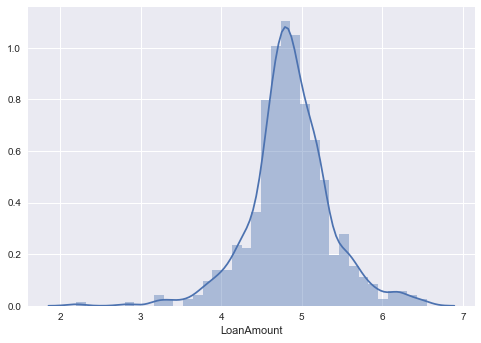

In [28]:
sns.distplot(train_test.LoanAmount.dropna())

In [29]:
temp_loan_amount = train_test.LoanAmount.fillna(train_test.LoanAmount.mean())

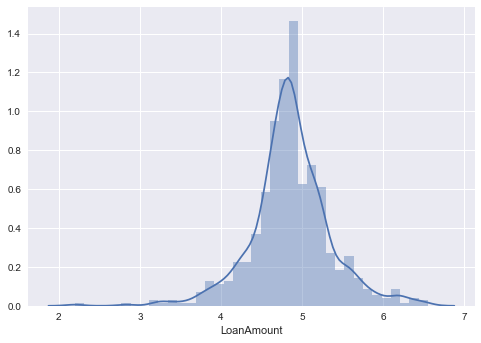

In [30]:
sns.distplot(temp_loan_amount)

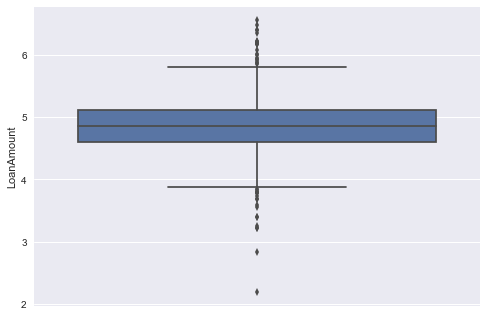

In [31]:
sns.boxplot(y=temp_loan_amount)

In [32]:
# Imputing missing Loan Amount with mean value #
train_test.LoanAmount.fillna(train_test.LoanAmount.mean(), inplace=True)

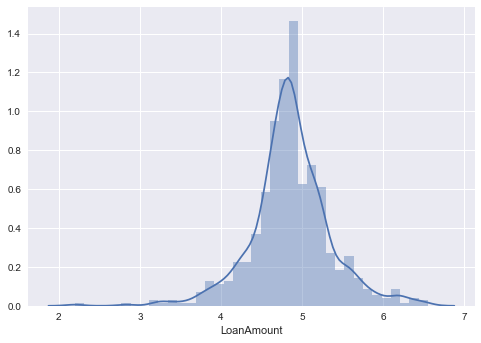

In [33]:
sns.distplot(train_test.LoanAmount)

In [34]:
train_test.dtypes

Gender                  int8
Married                 int8
Dependents             int64
Education               int8
Self_Employed           int8
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term       int64
Credit_History         int64
Property_Area           int8
dtype: object

In [35]:
train_test.head(n=2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,5849,0.0,4.857444,360,1,2
1,1,1,1,0,0,4583,1508.0,4.852030,360,1,0


In [36]:
X = train_test.iloc[:ntrain, :]
X_test = train_test.iloc[ntrain:, :]

In [37]:
X.shape, X_test.shape, y.shape

((100, 11), (514, 11), (100,))

In [38]:
def model_report(clf_params=''):
    if clf_params != '':
        clf = xgb.XGBClassifier(**clf_params)
    else:
        clf = xgb.XGBClassifier()
    y_pred = clf.fit(X, y).predict(X)
    #print('----->>>>',y[1:3], y_pred[1:3])
    y_pred_probs = clf.predict_proba(X)[:,1]
    cv_score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')
     #Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y, y_pred))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_pred_probs))
    # Print CV Score:
    print("CV Score| Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % 
                (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #Print Feature Importance:
    feat_imp = pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=True)
    feat_imp.plot(kind='barh', title='Feature Importances', figsize=(15,5), )
    plt.xlabel('Feature Importance Score')

Model Report
Accuracy : 0.98
AUC Score (Train): 1.000000
CV Score| Mean: 0.8230159 | Std: 0.1460964 | Min: 0.5555556 | Max: 1


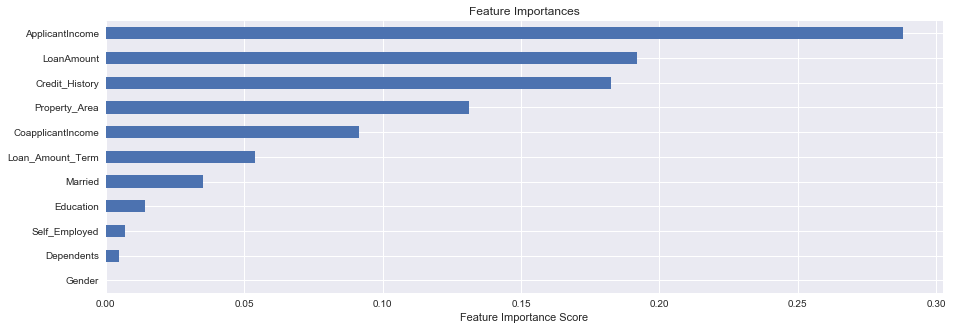

In [39]:
model_report()

In [40]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [53]:
# Parameter Tuning #
clf_params = {
    'seed': 1234,
    'silent': 0,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic'
}
param_dist = {
    'min_child_weight': [1,3,5],
    'max_depth': list(range(3, 20)),
    'learning_rate': st.uniform(0.05, 0.4), 
    'subsample': [0.7,0.8,0.9],
    'n_estimators':range(20,81,10)
}
n_iter_search = 20
xgb_clf = xgb.XGBClassifier(**clf_params)
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=n_iter_search,
                          scoring='accuracy', random_state=10, n_jobs=1, cv=10)

In [54]:
start = time.time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 19.48 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.830 (std: 0.083)
Parameters: {'min_child_weight': 1, 'subsample': 0.7, 'max_depth': 14, 'n_estimators': 60, 'learning_rate': 0.10251642114253534}

Model with rank: 2
Mean validation score: 0.820 (std: 0.089)
Parameters: {'min_child_weight': 1, 'subsample': 0.7, 'max_depth': 14, 'n_estimators': 30, 'learning_rate': 0.068758527755699905}

Model with rank: 2
Mean validation score: 0.820 (std: 0.089)
Parameters: {'min_child_weight': 1, 'subsample': 0.7, 'max_depth': 19, 'n_estimators': 40, 'learning_rate': 0.1007887365806493}



In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import graphviz

In [57]:
# Cross Validation (CV): 
#   10-fold CV: data split in 10 parts, fit on 9 of them, test on the 10th part
#   This is repeated on all combinations to produce 10 estimates of the accuracy of the model
dt_ = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt_.fit(X, y)
scores = cross_val_score(dt_, X, y, cv=10)
print('mean: {:.3f} (std: {:.3f})'.format(scores.mean(), scores.std()), end='\n\n')

mean: 0.801 (std: 0.106)



In [58]:
# mean: 0.960 implies average accuracy(percentage of correct classification using the trained model) is 96%
# ----- USE OF HYPERPARAMETER TUNING TO IMPROVE ACCURACY ----- #
param_dist = {"criterion": ["gini", "entropy"],
              "min_samples_split": st.randint(2, 20),
              "max_depth": st.randint(1, 20),
              "min_samples_leaf": st.randint(1, 20),
              "max_leaf_nodes": st.randint(2, 20)}
dtc = DecisionTreeClassifier()

In [59]:
gs = RandomizedSearchCV(dtc, param_dist, n_jobs=1, n_iter=288)
start = time.time()
gs.fit(X,y)
print(("RandomizedSearchCV took {:.2f} "
       "seconds for {:d} candidates parameter settings.").format((time.time() - start), 288))
gs.best_score_, gs.best_params_

RandomizedSearchCV took 2.25 seconds for 288 candidates parameter settings.


(0.84999999999999998,
 {'criterion': 'entropy',
  'max_depth': 15,
  'max_leaf_nodes': 3,
  'min_samples_leaf': 2,
  'min_samples_split': 5})

In [60]:
report(gs.cv_results_)

Model with rank: 1
Mean validation score: 0.850 (std: 0.051)
Parameters: {'max_depth': 15, 'criterion': 'entropy', 'max_leaf_nodes': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}

Model with rank: 1
Mean validation score: 0.850 (std: 0.051)
Parameters: {'max_depth': 10, 'criterion': 'gini', 'max_leaf_nodes': 3, 'min_samples_split': 11, 'min_samples_leaf': 2}

Model with rank: 1
Mean validation score: 0.850 (std: 0.044)
Parameters: {'max_depth': 2, 'criterion': 'entropy', 'max_leaf_nodes': 11, 'min_samples_split': 7, 'min_samples_leaf': 1}

Model with rank: 1
Mean validation score: 0.850 (std: 0.051)
Parameters: {'max_depth': 2, 'criterion': 'entropy', 'max_leaf_nodes': 13, 'min_samples_split': 19, 'min_samples_leaf': 3}

Model with rank: 1
Mean validation score: 0.850 (std: 0.051)
Parameters: {'max_depth': 8, 'criterion': 'gini', 'max_leaf_nodes': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}

Model with rank: 1
Mean validation score: 0.850 (std: 0.051)
Parameters: {'max_depth'

In [62]:
# test the retuned best parameters
clf_params = {
    'criterion': 'entropy', 
    'max_depth': 15, 
    'max_leaf_nodes': 3, 
    'min_samples_leaf': 2, 
    'min_samples_split': 5
}
dtc = DecisionTreeClassifier(**clf_params)
scores = cross_val_score(dtc, X, y, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(), scores.std()))

mean: 0.847 (std: 0.099)


In [70]:
predictions = dtc.fit(X,y).predict(X_test)

In [73]:
y_pred = ['Y' if x > 0.5 else 'N' for x in predictions]

In [74]:
# create loan eligibility submission file
ds_subs_1 = pd.DataFrame(data=[], columns=['Application_ID', 'Loan_Status'])
ds_subs_1.Application_ID = test_ID; ds_subs_1.Loan_Status = y_pred
ds_subs_1.to_csv('submission.csv', index=False)
ds_subs_1.head()

,Application_ID,Loan_Status
0,1345,Y
1,1349,Y
2,1350,Y
3,1356,Y
4,1357,Y


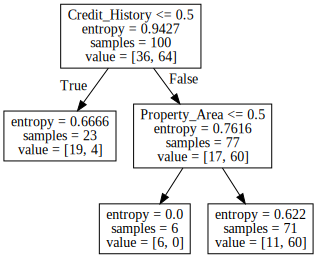

In [72]:
export_graphviz(dtc, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)